In [1]:
import os
import random
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

BASE_DIR = "/kaggle/input/skin-cancer-mnist-ham10000"
IMG_DIRS = [
    os.path.join(BASE_DIR, "HAM10000_images_part_1"),
    os.path.join(BASE_DIR, "HAM10000_images_part_2"),
]
META_PATH = os.path.join(BASE_DIR, "HAM10000_metadata.csv")
OUT_DIR = "output"
splits = ["train", "val", "test"]




# Load metadata
df = pd.read_csv(META_PATH)

# Use original 7 HAM10000 classes
df["label"] = df["dx"]

classes = sorted(df["label"].unique())
print("Classes:", classes)



# Create directories
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(OUT_DIR, split, cls), exist_ok=True)

# Find image paths
def find_image(image_id):
    for d in IMG_DIRS:
        path = os.path.join(d, image_id + ".jpg")
        if os.path.exists(path):
            return path
    return None

df["image_path"] = df["image_id"].apply(find_image)
df = df.dropna(subset=["image_path"])

# Train / val / test split (70 / 15 / 15)
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=42
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42
)

# Function to copy images
def copy_images(dataframe, split_name):
    for _, row in dataframe.iterrows():
        dst = os.path.join(
            OUT_DIR,
            split_name,
            row["label"],
            os.path.basename(row["image_path"])
        )
        shutil.copy(row["image_path"], dst)

copy_images(train_df, "train")
copy_images(val_df, "val")
copy_images(test_df, "test")

print("Merge and split completed successfully")

Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Merge and split completed successfully


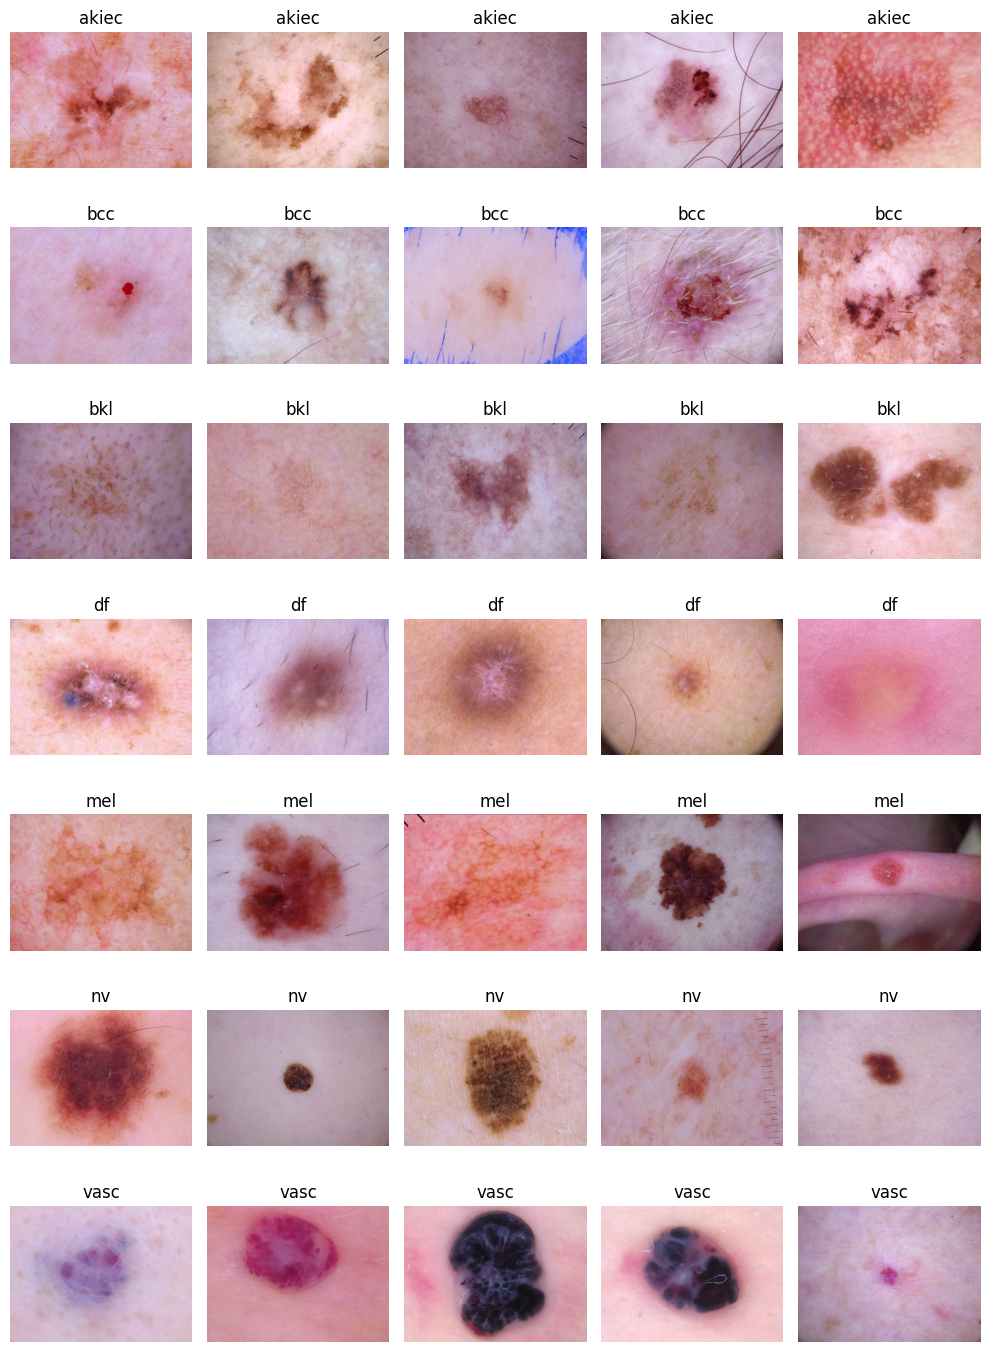

In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

TRAIN_DIR = "output/train"
classes = sorted(os.listdir(TRAIN_DIR))
images_per_class = 5
num_classes = len(classes)
plt.figure(figsize=(images_per_class * 2, num_classes * 2))
img_index = 1
for cls in classes:
    cls_path = os.path.join(TRAIN_DIR, cls)
    imgs = random.sample(os.listdir(cls_path), min(images_per_class, len(os.listdir(cls_path))))
    for img_name in imgs:
        img_path = os.path.join(cls_path, img_name)
        img = Image.open(img_path)
        plt.subplot(num_classes, images_per_class, img_index)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
        img_index += 1
plt.tight_layout()
plt.show()

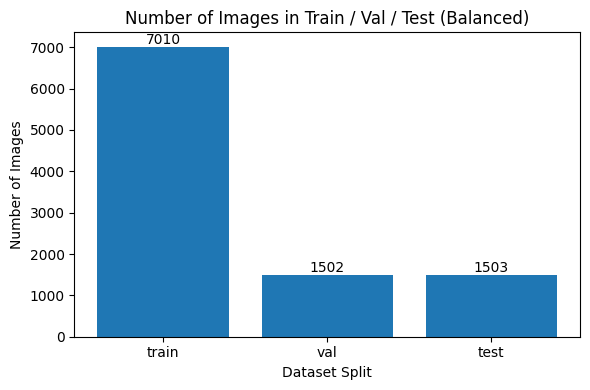

In [3]:
import os
import matplotlib.pyplot as plt

BASE_DIR = "output"
splits = ["train", "val", "test"]
classes = sorted(os.listdir(os.path.join(BASE_DIR, "train")))
counts = []
for split in splits:
    total = 0
    for cls in classes:
        path = os.path.join(BASE_DIR, split, cls)
        total += len(os.listdir(path))
    counts.append(total)

# Plot bar graph
plt.figure(figsize=(6,4))
plt.bar(splits, counts)
plt.title("Number of Images in Train / Val / Test (Balanced)")
plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
for i, v in enumerate(counts):
    plt.text(i, v, str(v), ha="center", va="bottom")
plt.tight_layout()
plt.show()

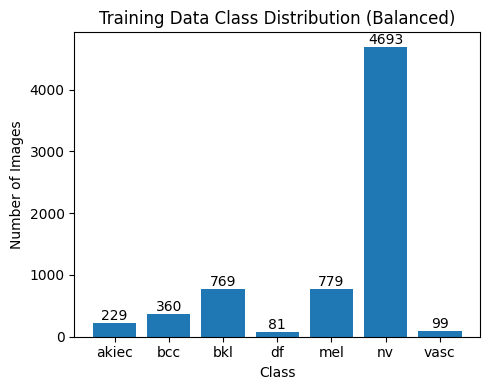

In [4]:

TRAIN_DIR = "output/train"
classes = sorted(os.listdir(os.path.join(BASE_DIR, "train")))
counts = []
for cls in classes:
    cls_path = os.path.join(TRAIN_DIR, cls)
    counts.append(len(os.listdir(cls_path)))

# Plot bar graph
plt.figure(figsize=(5,4))
plt.bar(classes, counts)
plt.title("Training Data Class Distribution (Balanced)")
plt.xlabel("Class")
plt.ylabel("Number of Images")
for i, v in enumerate(counts):
    plt.text(i, v, str(v), ha="center", va="bottom")
plt.tight_layout()
plt.show()

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Step 1: Define directories and parameters
TRAIN_DIR = "output/train"
VAL_DIR = "output/val"
TEST_DIR = "output/test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

2026-02-20 21:12:16.075527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771621936.303561      25 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771621936.365515      25 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771621936.870544      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771621936.870592      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771621936.870595      25 computation_placer.cc:177] computation placer alr

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.9, 1.1)
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [7]:
# Train generator
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

Found 7010 images belonging to 7 classes.


In [8]:
# Validation generator
val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 1502 images belonging to 7 classes.


In [9]:
# Test generator
test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 1503 images belonging to 7 classes.


In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_indices = train_gen.class_indices
print(class_indices)

labels = train_gen.classes

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Class Weights: {0: np.float64(4.37305053025577), 1: np.float64(2.7817460317460316), 2: np.float64(1.3022478172023035), 3: np.float64(12.36331569664903), 4: np.float64(1.285530900421786), 5: np.float64(0.21338772031292808), 6: np.float64(10.115440115440116)}


In [11]:
# Step 3: Load pretrained ResNet50 model and freeze it
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze the base model initially

I0000 00:00:1771621952.305525      25 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771621952.311499      25 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Step 4: Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
NUM_CLASSES = len(classes)
output = Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
# Fine-tune the model
history_fine = model.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen,
    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1771621964.673019      95 service.cc:152] XLA service 0x7b59e8004700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771621964.673065      95 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771621964.673069      95 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771621966.633582      95 cuda_dnn.cc:529] Loaded cuDNN version 91002


  2/220 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.0547 - loss: 1.4920 

I0000 00:00:1771621972.043717      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


220/220 ━━━━━━━━━━━━━━━━━━━━ 158s 651ms/step - accuracy: 0.1292 - loss: 2.1009 - val_accuracy: 0.1112 - val_loss: 1.9588
Epoch 2/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 131s 597ms/step - accuracy: 0.1014 - loss: 2.0350 - val_accuracy: 0.1105 - val_loss: 1.9582
Epoch 3/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 129s 585ms/step - accuracy: 0.0918 - loss: 2.0380 - val_accuracy: 0.1112 - val_loss: 1.9137
Epoch 4/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 128s 583ms/step - accuracy: 0.1205 - loss: 1.8968 - val_accuracy: 0.3515 - val_loss: 1.9287
Epoch 5/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 129s 586ms/step - accuracy: 0.1021 - loss: 1.9916 - val_accuracy: 0.0519 - val_loss: 1.9537


In [14]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [15]:
history_ft = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    class_weight=class_weights
)

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 162s 645ms/step - accuracy: 0.1121 - loss: 1.9796 - val_accuracy: 0.0513 - val_loss: 2.0837
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 130s 590ms/step - accuracy: 0.2118 - loss: 1.8711 - val_accuracy: 0.0939 - val_loss: 1.7000
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 131s 595ms/step - accuracy: 0.2538 - loss: 1.7852 - val_accuracy: 0.2284 - val_loss: 1.5460
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 130s 592ms/step - accuracy: 0.3400 - loss: 1.7135 - val_accuracy: 0.2330 - val_loss: 1.8793
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 131s 595ms/step - accuracy: 0.3858 - loss: 1.6586 - val_accuracy: 0.1032 - val_loss: 1.8589
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 128s 581ms/step - accuracy: 0.3533 - loss: 1.5766 - val_accuracy: 0.2710 - val_loss: 1.6362
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 131s 596ms/step - accuracy: 0.4015 - loss: 1.4744 - val_accuracy: 0.1132 - val_loss: 2.3867
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 130s 593ms/step - accuracy: 0.4239 -

In [16]:
history_ft = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    class_weight=class_weights
)

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 130s 591ms/step - accuracy: 0.5042 - loss: 1.3565 - val_accuracy: 0.3509 - val_loss: 1.6270
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 129s 587ms/step - accuracy: 0.5076 - loss: 1.3341 - val_accuracy: 0.0353 - val_loss: 4.9417
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 130s 592ms/step - accuracy: 0.5019 - loss: 1.3103 - val_accuracy: 0.1305 - val_loss: 2.2886
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 131s 593ms/step - accuracy: 0.4904 - loss: 1.3001 - val_accuracy: 0.4660 - val_loss: 1.3340
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 131s 593ms/step - accuracy: 0.4813 - loss: 1.3605 - val_accuracy: 0.5173 - val_loss: 1.2066
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 130s 591ms/step - accuracy: 0.5180 - loss: 1.2820 - val_accuracy: 0.2916 - val_loss: 1.5598
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 130s 591ms/step - accuracy: 0.4899 - loss: 1.2683 - val_accuracy: 0.0826 - val_loss: 3.0352
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 132s 597ms/step - accuracy: 0.5260 -

In [17]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [18]:
history_ft3 = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    class_weight=class_weights
)

Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 153s 635ms/step - accuracy: 0.5339 - loss: 1.1738 - val_accuracy: 0.5959 - val_loss: 1.0468
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 131s 593ms/step - accuracy: 0.5502 - loss: 1.1246 - val_accuracy: 0.5093 - val_loss: 1.2467
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 132s 601ms/step - accuracy: 0.5435 - loss: 1.1688 - val_accuracy: 0.5772 - val_loss: 1.0179
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 128s 582ms/step - accuracy: 0.5623 - loss: 1.0929 - val_accuracy: 0.5632 - val_loss: 1.0735
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 128s 583ms/step - accuracy: 0.5553 - loss: 1.0847 - val_accuracy: 0.4967 - val_loss: 1.2642
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 130s 588ms/step - accuracy: 0.5611 - loss: 1.1168 - val_accuracy: 0.5892 - val_loss: 0.9778
Epoch 7/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 130s 590ms/step - accuracy: 0.5569 - loss: 1.1088 - val_accuracy: 0.4314 - val_loss: 1.3977
Epoch 8/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 125s 567ms/step - accuracy: 0.5438 -

In [19]:
test_results = model.evaluate(test_gen)
print(dict(zip(model.metrics_names, test_results)))

47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 319ms/step - accuracy: 0.4754 - loss: 1.4150
{'loss': 1.2724825143814087, 'compile_metrics': 0.49567532539367676}


In [20]:
# Step 9: Generate predictions for confusion matrix and classification report
y_true = test_gen.classes
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 281ms/step
Confusion Matrix:
[[ 24   5   4  11   4   0   1]
 [ 10  26   2  26   7   1   5]
 [ 15   5  57  42  29  13   4]
 [  1   1   2  10   2   1   0]
 [ 15   1  23  15 101   7   5]
 [ 15  13  66 171 181 516  44]
 [  2   2   0   4   2   1  11]]


In [21]:


# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

       akiec       0.29      0.49      0.37        49
         bcc       0.49      0.34      0.40        77
         bkl       0.37      0.35      0.36       165
          df       0.04      0.59      0.07        17
         mel       0.31      0.60      0.41       167
          nv       0.96      0.51      0.67      1006
        vasc       0.16      0.50      0.24        22

    accuracy                           0.50      1503
   macro avg       0.37      0.48      0.36      1503
weighted avg       0.75      0.50      0.57      1503



In [22]:

# Step 10: Save the model
model.save("model_resnet50_skin_cancer_001.h5")
print("Model saved successfully")


Model saved successfully


In [23]:
import pandas as pd

pd.DataFrame(history_ft3.history).to_csv("multiclass_history.csv", index=False)

model.save("model_resnet50_multiclass.h5")

print("Multiclass model and history saved successfully")

Multiclass model and history saved successfully
